In [1]:
# Copyright (c) 2024 Graphcore Ltd. All rights reserved.

# Batching

Training neural networks over batches of data is an essential component of efficiently
utilising massively parallel hardware accelerators. We can recast a standard electronic
minimisation problem as a batched one by using the JAX vectorising map
[aka jax.vmap](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html#jax-vmap).
By doing this we can parallelise the electronic structure optimisation over multiple
conformations of the same molecule.  Just like in training neural networks, this will
allow for more efficient utilisation of the accelerator which unlocks
exploring the
[potential energy surfaces](https://en.wikipedia.org/wiki/Potential_energy_surface)
using quantum-mechanical simulations.

We demonstrate this idea by calculating the molecular Hydrogen dissociation curve using
a batch of hydrogen molecules where the bond length (H-H distance) is varied.  To setup
the batch we build a `Hamiltonian` for each bond length and stack the built modules to
create a batched-Hamiltonian.  This example uses the `sto-3g` basis set and the simple
local density approximation of density functional theory but the this formulation isn't
unique to these choices for how the Hamiltonian is represented.

:::{note}
The following code cell will install MESS into the Google Colab runtime.
Select the 🚀 in the toolbar above to try this out!
:::

In [2]:
import sys

if 'google.colab' in sys.modules:
    !pip install git+https://github.com/graphcore-research/mess.git


  Cloning https://github.com/graphcore-research/mess.git to /tmp/pip-req-build-yle2xylj
  Running command git clone --filter=blob:none --quiet https://github.com/graphcore-research/mess.git /tmp/pip-req-build-yle2xylj
  Resolved https://github.com/graphcore-research/mess.git to commit 099a73ba3135854519986351090884c9b9dc0cb8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/rpmuller/pyquante2 (to revision pure) to /tmp/pip-install-25dcsqwy/pyquante2_a1d8959b4fb34b83a3c262912498bcac
  Running command git clone --filter=blob:none --quiet https://github.com/rpmuller/pyquante2 /tmp/pip-install-25dcsqwy/pyquante2_a1d8959b4fb34b83a3c262912498bcac
  Running command git checkout -b pure --track origin/pure
  Switched to a new branch 'pure'
  Branch 'pure' set up to track remote branch 'pure' from 'origin'.
  Resolved https://github.com/rpm

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
import seaborn as sns
from tqdm.notebook import tqdm

from mess import Hamiltonian, basisset
from mess.structure import Structure, nuclear_energy

sns.set_theme(style="whitegrid")

In [4]:
def h2_hamiltonian(r: float, basis_name: str = "sto-3g", xc_method="lda"):
    mol = Structure(
        atomic_number=np.array([1, 1]),
        position=np.array([[0.0, 0.0, 0.0], [r, 0.0, 0.0]]),
    )
    basis = basisset(mol, basis_name=basis_name)
    return Hamiltonian(basis, xc_method=xc_method)


num_confs = 64
rs = np.linspace(0.6, 10, num_confs)
H = [h2_hamiltonian(r) for r in rs]
num_orbitals = H[0].basis.num_orbitals
H = jax.tree.map(lambda *xs: jnp.stack(xs), *H)

Next is where the magic happens using the vectorising transformation from JAX.  
The `energy` function evaluates the energy of a single `Hamiltonian` for the unconstrained
trial matrix $Z$.  The `@jax.vmap` converts this simple function to work on the batched
Hamiltonian we constructed earlier.  For an extra performance boost we use the
[jax.jit](https://jax.readthedocs.io/en/latest/_autosummary/jax.jit.html#jax-jit)
function transformation to compile this function.

In [5]:
@jax.jit
@jax.vmap
def energy(Z, H):
    C = H.orthonormalise(Z)
    P = H.basis.density_matrix(C)
    return H(P)

Next we setup an initial guess and a gradient descent optimiser
([adam](https://optax.readthedocs.io/en/latest/api/optimizers.html#optax.adam) from the optax library)
that will solve the batched energy minimisation problem.

The initial guess is somewhat arbitrary and there are certainly better methods that one
could use for initialisation.

In [6]:
Z = jnp.tile(jnp.eye(num_orbitals), (num_confs, 1, 1))
optimiser = optax.adam(learning_rate=0.1)
state = optimiser.init(Z)

Finally we are ready to run the optimisation.  We define a simple loss function that
simply takes the sum over the energy for each molecular conformation in the batch.
In simple terms, the optimisation will follow the gradient to make this sum as small as
possible.  We use the transformation
[jax.value_and_grad](https://jax.readthedocs.io/en/latest/_autosummary/jax.value_and_grad.html)
as a function decorator on this loss function to evaluate the loss and the corresponding
gradient.  Note that the gradient is computed using automatic differentiation.

In [7]:
@jax.value_and_grad
def loss_fn(z, h):
    return jnp.sum(energy(z, h))


history = []

for _ in (bar := tqdm(range(128))):
    loss, grads = loss_fn(Z, H)
    updates, state = optimiser.update(grads, state)
    Z = optax.apply_updates(Z, updates)
    history.append(loss)
    bar.set_description(f"Loss {loss:0.06f}")

  0%|          | 0/128 [00:00<?, ?it/s]

As sanity check we plot the loss to see if there is any funny business to investigate

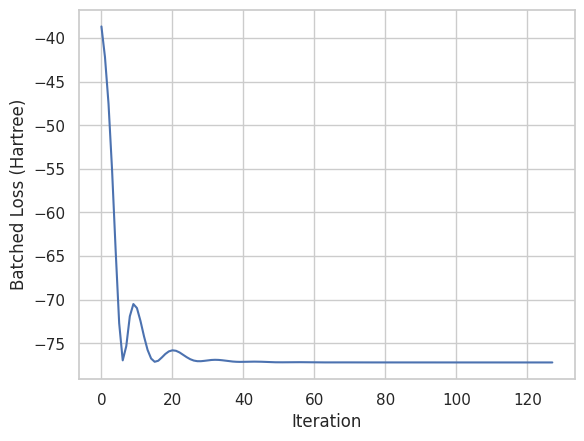

In [8]:
history = jnp.stack(history)
ax = sns.lineplot(history)
ax.set_xlabel("Iteration")
ax.set_ylabel("Batched Loss (Hartree)");

The loss is decreasing so looks good!

Finally we can evaluate the total energy by once again using our now good friend the
vectorising map to compute the `nuclear_energy` for each conformation.  This is added
to the electronic energy we minimised above.  Finally we can plot the dissociation
curve which looks like something you can find in your nearest chemistry textbook.

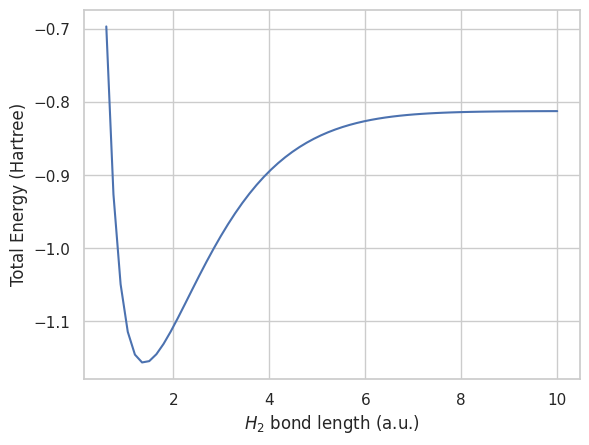

In [9]:
E_n = jax.vmap(nuclear_energy)(H.basis.structure)
E_total = energy(Z, H) + E_n

ax = sns.lineplot(x=rs, y=E_total)
ax.set_xlabel("$H_2$ bond length (a.u.)")
ax.set_ylabel("Total Energy (Hartree)");